In [1]:
# Must run
!python -m spacy download en_core_web_sm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/yifanyu/miniconda3/envs/hf/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/Users/yifanyu/miniconda3/envs/hf/lib/python3.10/runpy.py", line 146, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/Users/yifanyu/miniconda3/envs/hf/lib/python3.10/runpy.py", line 110, in _get_module_details
    __import__(pkg_name)
  File "/Users/yifanyu/miniconda3/envs/hf/lib/python3.10/site-packages/spacy/_

# Two Way

In [ ]:
# nvidia-smi

# Standard library
import os
import gc
import random
import math

# Third-party
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm
from huggingface_hub import login
import matplotlib.pyplot as plt
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModel,
)


# Local package imports
from rc_experiment.data_loading import raw_2_llm_data, torch_data_loader
from rc_experiment.model_loading import quanti_lora_md
from rc_experiment.training import casual_llm_train, plot_losses
from rc_experiment.eval import rc_eval

login(token="YOUR_TOKEN")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if hasattr(torch, 'mps') and torch.backends.mps.is_available() else "cpu")


########################################################
# Define Experiment Configuration
########################################################
## Original RC Data files paths
# TRAINING_FILES = {
#     "train": "pipeline_test_data/all_prompts_train.jsonl",
#     "validation": "pipeline_test_data/validation_prompts.jsonl",
# }

# TEST_FILES = {
#     "p2d": "pipeline_test_data/p2d_prompts_test.jsonl",
#     "d2p": "pipeline_test_data/d2p_prompts_test.jsonl"
# }


# #  Complex RC Data files paths
# TRAINING_FILES = {
#     "train": "pipeline_test_data/train.jsonl",
#     "validation": "pipeline_test_data/final_augmented_without_added.jsonl",
# }

# TEST_FILES = {"test": "pipeline_test_data/final_augmented_without_added.jsonl"}


# # Spatial RC Data Path
# TRAINING_FILES = {
#     "train": "pipeline_test_data/a2b_prompts_train.jsonl",
#     "validation": "pipeline_test_data/validation_prompts_a2b.jsonl",
# }

# TEST_FILES = {
#     "test": "pipeline_test_data/validation_prompts_a2b.jsonl",
#     }


# # one-way data path
# TRAINING_FILES = {
#     "1wtrain": "pipeline_test_data/all_prompts_train.jsonl",
#     "1wvalidation": "pipeline_test_data/validation_prompts.jsonl",
# }

# TEST_FILES = {
#     "1wp2d": "pipeline_test_data/p2d_prompts_test.jsonl",
#     "1wd2p": "pipeline_test_data/d2p_prompts_test.jsonl",
#     "1wtest": "pipeline_test_data/ont_way_validation.jsonl"
# }
# train_loader_name = "1wtrain_loader"
# val_loader_name = "1wvalidation_loader"

# two-way data path
TRAINING_FILES = {
    "2wtrain": "pipeline_test_data/all_prompts_train.jsonl",
    "2wvalidation": "pipeline_test_data/validation.jsonl",
}
train_file_name = "2wtrain"


TEST_FILES = {
    "2wp2d": "pipeline_test_data/p2d_prompts_test.jsonl",
    "2wd2p": "pipeline_test_data/d2p_prompts_test.jsonl"}
train_loader_name = "2wtrain_loader"
val_loader_name = "2wvalidation_loader"

# Choose a small causal model from Hugging Face (for example, LLaMA-2 7B or OPT 125M)
# TinyLlama has the same architecture as the Llama 2

MODELS = [
        # "Qwen/Qwen3-0.6B",
        "meta-llama/Llama-3.2-1B",
        "allenai/OLMo-2-0425-1B-Instruct",
        "TinyLlama/TinyLlama-1.1B-Chat-v0.1",
        # "Qwen/Qwen3-1.7B",
        ]
BEST_MODEL_DIR = []  # Wait to receieve

# Define max sequence lengths for prompt and completion
MAX_INPUT_LENGTH = 256    # maximum tokens for the prompt
MAX_TARGET_LENGTH = 20    # maximum tokens for the completion/response
TOTAL_MAX_LENGTH = MAX_INPUT_LENGTH + MAX_TARGET_LENGTH

# LoRA Configuration
LORA_CONFIG_KWARGS = {
    "r": 16,               # LoRA rank
    "lora_alpha": 16,       # LoRA scaling factor
    "lora_dropout": 0.05,   # LoRA dropout
    "bias": "none",         # Bias handling
    "task_type": "CAUSAL_LM" # Task type
}

# Training config
BATCH_SIZE = 4
TRAIN_PORTION_RATE = 1
NUM_EPOCHS = 20  # you can adjust the number of fine-tuning epochs
PATIENCE = 2    # early stopping PATIENCE
MIN_DELTA = 0.01 # minimum change in val loss to qualify as an improvement

# Define a global instruction prompt (can be multi-line or structured as needed)
INSTRUCTION_PROMPT = "You are a knowledgeable assistant skilled at factual recall. When given a person's name, you can return the description of that person. When given a description, you can return the name of the person that fit the description."

# Loop all the model names to conduct experiments
for k, model_name in enumerate(MODELS):
    print("")
    print(f"*** Experiment start for {model_name} ***")
    print("")
    ########################################################
    # Data Loading & Pre-processing & Tokenization
    ########################################################       
    # Preprocess the training data with the instruction (if INSTRUCTION_PROMPT is None or "", no instruction will be applied)
    tokenized_datasets, tokenizer, device = raw_2_llm_data(TRAINING_FILES, model_name, 
                                                        MAX_INPUT_LENGTH, MAX_TARGET_LENGTH, 
                                                        instruction=INSTRUCTION_PROMPT)

    ########################################################
    # Set Up Pytroch Data Loader
    ########################################################
    # Obtian the DataLoader dictionary
    loader_dict = torch_data_loader(tokenized_datasets, train_file_name, batch_size=BATCH_SIZE, train_portion_rate=TRAIN_PORTION_RATE)
    # Unpack the loader
    train_loader = loader_dict[train_loader_name]
    val_loader = loader_dict[val_loader_name]

    ########################################################
    # Load LoRA Model
    ########################################################
    # load the quantized lora model
    model = quanti_lora_md(LORA_CONFIG_KWARGS, model_name)
    # move the model to device
    model = model.to(device)

    ########################################################
    # Training (Finetuning) + Save the best model
    ########################################################
    # Define optimizer (AdamW) to update only trainable params (LoRA adapters)
    learning_rate = 5e-5
    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=learning_rate)

    # Save the best model's config
    saving_dir, train_losses, val_losses, val_accuracies = casual_llm_train(model_name, model, tokenizer, optimizer, train_loader, val_loader, device,
                                                                            MAX_TARGET_LENGTH, NUM_EPOCHS, PATIENCE, MIN_DELTA)
    BEST_MODEL_DIR.append(saving_dir)

    plot_losses(train_losses, val_accuracies, model_name=model_name)
    
    """
    ########################################################
    # Load in tuned model (Optional)
    ########################################################
    
    # Load in model config
    base_model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    lora_weights_path = BEST_MODEL_DIR[i]
    model = PeftModel.from_pretrained(base_model, lora_weights_path)
    model.to(device)
    """
    
    ########################################################
    # Evaluation on all test sets
    ########################################################
    for test_name, path in TEST_FILES.items():
        test_path = {test_name: path}

        test_datasets, _, _ = raw_2_llm_data(test_path, model_name, 
                                     MAX_INPUT_LENGTH, MAX_TARGET_LENGTH, 
                                     instruction=INSTRUCTION_PROMPT)
        # Obtian the DataLoader dictionary
        test_loader_dict = torch_data_loader(test_datasets, "NO_TEST_SET", batch_size=2)
        
        print(test_loader_dict)
        # Get the data loader
        test_loader = test_loader_dict[f"{test_name}_loader"]

        pred_rslt_df = rc_eval(test_loader, model, tokenizer, device, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH, INSTRUCTION_PROMPT)

        # save the data frame
        folder_path = f"experiment_rslt/{model_name}"
        os.makedirs(folder_path, exist_ok=True)
        save_path = os.path.join(folder_path, f"{test_name}_results.csv")
        pred_rslt_df.to_csv(save_path, index=False)

        print(f"DataFrame successfully saved to {save_path}")

    ########################################################
    # Clear the current model
    ########################################################

    def clear():
        global model, tokenizer
        del model
        del tokenizer
        gc.collect()

        # Conditionally clear GPU caches
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

    clear()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/yifanyu/miniconda3/envs/hf/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/yifanyu/miniconda3/envs/hf/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/yifanyu/miniconda3/envs/hf/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/yifanyu/miniconda3/envs/hf/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, 


*** Experiment start for meta-llama/Llama-3.2-1B ***



KeyboardInterrupt: 

: 

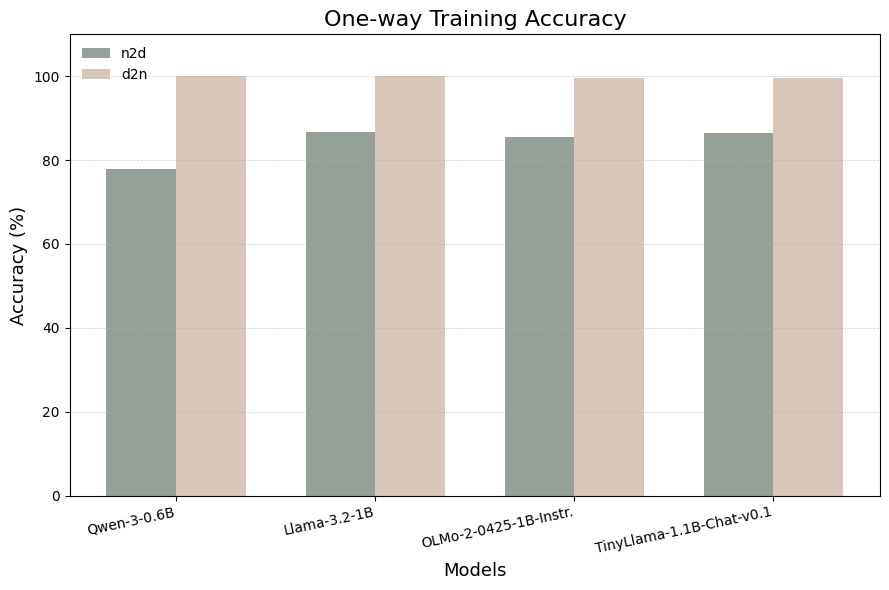

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_one_way_results():
    """
    Bar chart of one-way training accuracy using a strong, elegant color scheme.
    Each model has two bars: n2d (name → description), d2n (description → name).
    """

    # --- Data ---
    models = [
        "Qwen-3-0.6B",
        "Llama-3.2-1B",
        "OLMo-2-0425-1B-Instr.",
        "TinyLlama-1.1B-Chat-v0.1",
    ]
    n2d = [77.82, 86.65, 85.62, 86.58]
    d2n = [100.00, 100.00, 99.67, 99.67]

    # --- Custom Colors ---
    n2d_color = "#95A098"  # Slate Purple
    d2n_color = "#D8C6BA"  # Amber Gold

    # --- Plot setup ---
    x = np.arange(len(models))
    width = 0.35
    fig, ax = plt.subplots(figsize=(9, 6))

    ax.bar(x - width/2, n2d, width, label="n2d", color=n2d_color)
    ax.bar(x + width/2, d2n, width, label="d2n", color=d2n_color)

    # --- Labels and style ---
    ax.set_title("One-way Training Accuracy", fontsize=16)
    ax.set_ylabel("Accuracy (%)", fontsize=13)
    ax.set_xlabel("Models", fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=12, ha="right")
    ax.set_ylim(0, 110)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

    # --- Legend with matching colors ---
    legend_elements = [
        Patch(facecolor=n2d_color, label="n2d"),
        Patch(facecolor=d2n_color, label="d2n")
    ]
    ax.legend(handles=legend_elements, frameon=False)

    fig.tight_layout()
    return fig, ax

# Example usage:
fig, ax = plot_one_way_results()
plt.show()